In [1]:
"""

  pip install gradio pandas pillow

"""

import os
import time
import random
import uuid
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import pandas as pd
from PIL import Image, ImageDraw
import gradio as gr


EMOTIONS = ["happy", "sad", "angry", "surprised", "neutral"]
OPTIONS_PER_QUESTION = 4
TRIALS_PER_SESSION = 20
CSV_LOG_PATH = "responses_log_cartoon.csv"

CANVAS_SIZE = 384


REPEAT_EVERY = 5
MIN_POOL_BEFORE_REPEAT = 3


CSV_COLUMNS = [
    "session_id",
    "trial_id",
    "timestamp_iso",
    "emotion_shown",
    "options_shown",
    "selected_label",
    "is_correct",
    "response_time_sec",
    "processing_time_ms",
    "seed",
    "repeat_id",
    "is_repeat"
]

def ensure_csv_header(path: str):
    if not os.path.exists(path):
        pd.DataFrame(columns=CSV_COLUMNS).to_csv(path, index=False)

def append_row(path: str, row: Dict):
    ensure_csv_header(path)
    pd.DataFrame([row]).to_csv(path, mode="a", header=False, index=False)



def draw_cartoon_face(emotion: str, seed: int) -> Image.Image:
    rng = random.Random(seed)
    img = Image.new("RGB", (CANVAS_SIZE, CANVAS_SIZE), "white")
    d = ImageDraw.Draw(img)


    pad = 30
    face_bbox = (pad, pad, CANVAS_SIZE - pad, CANVAS_SIZE - pad)
    d.ellipse(face_bbox, outline="black", width=6, fill=(255, 235, 170))


    cx = CANVAS_SIZE // 2 + rng.randint(-8, 8)
    cy = CANVAS_SIZE // 2 + rng.randint(-8, 8)


    eye_y = cy - 50 + rng.randint(-6, 6)
    eye_dx = 70 + rng.randint(-8, 8)
    eye_w = 28 + rng.randint(-5, 5)
    eye_h = 20 + rng.randint(-5, 5)

    left_eye = (cx - eye_dx - eye_w, eye_y - eye_h, cx - eye_dx + eye_w, eye_y + eye_h)
    right_eye = (cx + eye_dx - eye_w, eye_y - eye_h, cx + eye_dx + eye_w, eye_y + eye_h)


    d.ellipse(left_eye, fill="black")
    d.ellipse(right_eye, fill="black")


    brow_y = eye_y - 35
    brow_len = 55
    brow_th = 6

    def line(x1, y1, x2, y2, w=brow_th):
        d.line((x1, y1, x2, y2), fill="black", width=w)

    lx1, lx2 = cx - eye_dx - brow_len//2, cx - eye_dx + brow_len//2
    rx1, rx2 = cx + eye_dx - brow_len//2, cx + eye_dx + brow_len//2

    if emotion == "angry":
        line(lx1, brow_y, lx2, brow_y + 12)
        line(rx1, brow_y + 12, rx2, brow_y)
    elif emotion == "sad":
        line(lx1, brow_y + 12, lx2, brow_y)
        line(rx1, brow_y, rx2, brow_y + 12)
    elif emotion == "surprised":
        line(lx1, brow_y - 10, lx2, brow_y - 10)
        line(rx1, brow_y - 10, rx2, brow_y - 10)
        d.ellipse(left_eye, outline="black", width=6, fill="white")
        d.ellipse(right_eye, outline="black", width=6, fill="white")
        pupil_r = 8
        d.ellipse((cx - eye_dx - pupil_r, eye_y - pupil_r,
                   cx - eye_dx + pupil_r, eye_y + pupil_r), fill="black")
        d.ellipse((cx + eye_dx - pupil_r, eye_y - pupil_r,
                   cx + eye_dx + pupil_r, eye_y + pupil_r), fill="black")
    else:
        line(lx1, brow_y, lx2, brow_y)
        line(rx1, brow_y, rx2, brow_y)


    mouth_y = cy + 70 + rng.randint(-8, 8)
    mouth_w = 160 + rng.randint(-15, 15)
    mouth_h = 70 + rng.randint(-10, 10)
    mx1, mx2 = cx - mouth_w//2, cx + mouth_w//2
    my1, my2 = mouth_y - mouth_h//2, mouth_y + mouth_h//2

    if emotion == "happy":
        d.arc((mx1, my1, mx2, my2), start=10, end=170, fill="black", width=8)
    elif emotion == "sad":
        d.arc((mx1, my1, mx2, my2), start=190, end=350, fill="black", width=8)
    elif emotion == "angry":
        d.line((mx1 + 20, mouth_y, mx2 - 20, mouth_y), fill="black", width=8)
        d.line((mx1 + 40, mouth_y + 10, mx2 - 40, mouth_y + 10), fill="black", width=4)
    elif emotion == "surprised":
        o_w, o_h = 70, 90
        d.ellipse((cx - o_w//2, mouth_y - o_h//2, cx + o_w//2, mouth_y + o_h//2),
                  outline="black", width=8, fill="white")
    else:
        d.line((mx1 + 25, mouth_y, mx2 - 25, mouth_y), fill="black", width=8)

    if emotion == "happy":
        cheek_r = 18
        d.ellipse((cx - 120 - cheek_r, cy + 30 - cheek_r, cx - 120 + cheek_r, cy + 30 + cheek_r),
                  fill=(255, 170, 170))
        d.ellipse((cx + 120 - cheek_r, cy + 30 - cheek_r, cx + 120 + cheek_r, cy + 30 + cheek_r),
                  fill=(255, 170, 170))

    return img


def sample_options(correct: str) -> List[str]:
    others = [e for e in EMOTIONS if e != correct]
    random.shuffle(others)
    opts = [correct] + others[:max(0, OPTIONS_PER_QUESTION - 1)]
    random.shuffle(opts)
    return opts


@dataclass
class StimulusItem:
    emotion: str
    seed: int
    repeat_id: str


@dataclass
class TrialState:
    session_id: str
    trial_id: int = 0
    trials_total: int = TRIALS_PER_SESSION


    correct: str = ""
    options: Optional[List[str]] = None
    seed: int = 0
    repeat_id: str = ""
    is_repeat: int = 0

    start_time: float = 0.0
    processing_time_ms: float = 0.0
    stimulus_pool: Optional[List[StimulusItem]] = None


def new_session() -> TrialState:
    return TrialState(
        session_id=str(uuid.uuid4())[:8],
        trial_id=0,
        stimulus_pool=[]
    )


def make_new_stimulus() -> StimulusItem:
    emotion = random.choice(EMOTIONS)
    seed = random.randint(0, 10_000_000)
    repeat_id = str(uuid.uuid4())[:8]
    return StimulusItem(emotion=emotion, seed=seed, repeat_id=repeat_id)


def pick_stimulus_for_trial(state: TrialState) -> Tuple[StimulusItem, int]:

    trial_number = state.trial_id + 1
    pool = state.stimulus_pool or []

    should_repeat = (
        REPEAT_EVERY > 0 and
        trial_number % REPEAT_EVERY == 0 and
        len(pool) >= MIN_POOL_BEFORE_REPEAT
    )

    if should_repeat:
        stim = random.choice(pool)
        return stim, 1

    stim = make_new_stimulus()
    pool.append(stim)
    state.stimulus_pool = pool
    return stim, 0


def next_trial(state: TrialState) -> Tuple[TrialState, Image.Image, str, List[str], str]:
    if state.trial_id >= state.trials_total:
        img = Image.new("RGB", (CANVAS_SIZE, CANVAS_SIZE), "white")
        return state, img, "Finished session!", [], f"{state.trials_total}/{state.trials_total}"

    stim, is_repeat = pick_stimulus_for_trial(state)

    state.correct = stim.emotion
    state.seed = stim.seed
    state.repeat_id = stim.repeat_id
    state.is_repeat = is_repeat

    state.options = sample_options(state.correct)


    t0 = time.perf_counter()
    img = draw_cartoon_face(state.correct, state.seed)
    state.processing_time_ms = round((time.perf_counter() - t0) * 1000, 4)


    state.start_time = time.time()

    prompt = "Which emotion is this face showing?"
    progress = f"{state.trial_id + 1}/{state.trials_total}"
    return state, img, prompt, state.options, progress


def start_session():
    state = new_session()
    state, img, prompt, options, progress = next_trial(state)
    return (
        state,
        img,
        prompt,
        gr.update(choices=options, value=None),
        progress,
        f"Session ID: {state.session_id}",
        ""
    )


def submit_answer(state: TrialState, selected: str):

    if state.trial_id >= state.trials_total:
        return (
            state,
            Image.new("RGB", (CANVAS_SIZE, CANVAS_SIZE), "white"),
            "✅ Finished session!",
            gr.update(choices=[], value=None),
            f"{state.trials_total}/{state.trials_total}",
            "",
            "Session already finished."
        )

    if not selected:
        img = draw_cartoon_face(state.correct, state.seed)
        return (
            state,
            img,
            "Please select an option.",
            gr.update(choices=state.options or [], value=None),
            f"{state.trial_id + 1}/{state.trials_total}",
            "",
            ""
        )

    rt = time.time() - state.start_time
    is_correct = int(selected == state.correct)

    row = {
        "session_id": state.session_id,
        "trial_id": state.trial_id,
        "timestamp_iso": time.strftime("%Y-%m-%dT%H:%M:%S"),
        "emotion_shown": state.correct,
        "options_shown": "|".join(state.options or []),
        "selected_label": selected,
        "is_correct": is_correct,
        "response_time_sec": round(rt, 4),
        "processing_time_ms": state.processing_time_ms,
        "seed": state.seed,
        "repeat_id": state.repeat_id,
        "is_repeat": state.is_repeat,
    }
    append_row(CSV_LOG_PATH, row)

    feedback = (
        f"{'✅ Correct' if is_correct else ' Not quite'} — {rt:.2f}s | "
        f"Your answer: {selected} | Correct: {state.correct} | "
        f"{'REPEAT' if state.is_repeat else 'NEW'} | "
        f"proc={state.processing_time_ms:.1f}ms"
    )

    # advance
    state.trial_id += 1
    if state.trial_id >= state.trials_total:
        img = Image.new("RGB", (CANVAS_SIZE, CANVAS_SIZE), "white")
        return (
            state,
            img,
            "✅ Finished session! CSV saved.",
            gr.update(choices=[], value=None),
            f"{state.trials_total}/{state.trials_total}",
            feedback,
            f"Saved to: {CSV_LOG_PATH}"
        )

    state, img, prompt, options, progress = next_trial(state)
    return (
        state,
        img,
        prompt,
        gr.update(choices=options, value=None),
        progress,
        feedback,
        ""
    )


def load_log_preview():
    if not os.path.exists(CSV_LOG_PATH):
        return pd.DataFrame()
    try:
        df = pd.read_csv(CSV_LOG_PATH)
        return df.tail(30)
    except Exception:
        return pd.DataFrame()


def download_log():
    ensure_csv_header(CSV_LOG_PATH)
    return CSV_LOG_PATH


with gr.Blocks() as demo:
    gr.Markdown("## Cartoon Emotion Quiz (No Dataset Needed) — With Latency + Stability Repeats")
    gr.Markdown(
        "- **processing_time_ms**: system latency to generate stimulus\n"
        "- **repeat_id / is_repeat**: repeats of same stimulus to measure stability (consistency)\n"
    )

    state = gr.State(new_session())

    with gr.Row():
        start_btn = gr.Button("Start Session")
        refresh_btn = gr.Button("Refresh Log Preview")

    session_info = gr.Textbox(label="Session", value="Not started")
    progress = gr.Textbox(label="Progress", value=f"0/{TRIALS_PER_SESSION}")

    img = gr.Image(label="Face", type="pil", height=360)
    prompt = gr.Textbox(label="Prompt", value="Press Start Session")
    choices = gr.Radio(label="Choose the emotion", choices=[])
    submit_btn = gr.Button("Submit")

    feedback = gr.Textbox(label="Feedback", value="")
    status = gr.Textbox(label="Status", value="")

    with gr.Row():
        download_btn = gr.Button("Download CSV Log")
        file_out = gr.File(label="CSV")

    log_preview = gr.Dataframe(label="Last 30 rows (preview)", value=pd.DataFrame())

    start_btn.click(
        fn=start_session,
        outputs=[state, img, prompt, choices, progress, session_info, status]
    )

    submit_btn.click(
        fn=submit_answer,
        inputs=[state, choices],
        outputs=[state, img, prompt, choices, progress, feedback, status]
    )

    refresh_btn.click(fn=load_log_preview, outputs=log_preview)
    download_btn.click(fn=download_log, outputs=file_out)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7cffc469045ffd9462.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Sample graph to analyze response, time taken, stability of the above method. The .csv file is in the folder

In [ ]:
import pandas as pd

CSV_LOG_PATH = "responses_log_cartoon.csv"
WINDOW = 5

df = pd.read_csv(CSV_LOG_PATH)


latest_session = df["session_id"].iloc[-1]
df_s = df[df["session_id"] == latest_session].copy()
df_s = df_s.sort_values("trial_id")


avg_proc = df_s["processing_time_ms"].mean()
print(f'Latency: "Average processing time per trial: {avg_proc:.2f} ms."')


avg_rt_ms = df_s["response_time_sec"].mean() * 1000
print(f'User latency: "Average response time: {avg_rt_ms:.2f} ms."')


rep = df_s[df_s["is_repeat"] == 1].copy()
if len(rep) == 0:
    print('Stability: "No repeats found (increase trials or lower REPEAT_EVERY)."')
else:

    rt_std_by_item = rep.groupby("repeat_id")["response_time_sec"].std()
    stability_rt = rt_std_by_item.mean()
    print(f'Stability: "Mean std-dev of response time on repeated stimuli: {stability_rt:.3f} sec."')

    # Consistency (accuracy on repeats)
    acc_by_item = rep.groupby("repeat_id")["is_correct"].mean()
    consistency = acc_by_item.mean()
    print(f'Stability: "Mean repeat consistency (accuracy): {consistency:.3f}."')


Latency: "Average processing time per trial: 0.43 ms."
User latency: "Average response time: 8724.01 ms."
Stability: "Mean std-dev of response time on repeated stimuli: 0.213 sec."
Stability: "Mean repeat consistency (accuracy): 0.833."


Using latest session_id: 5bc5cdc0


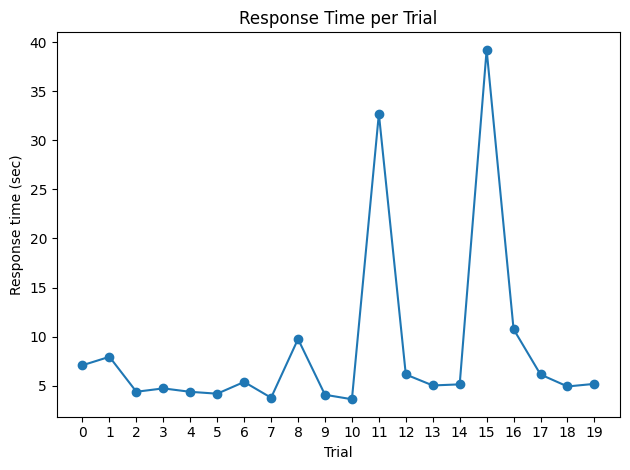

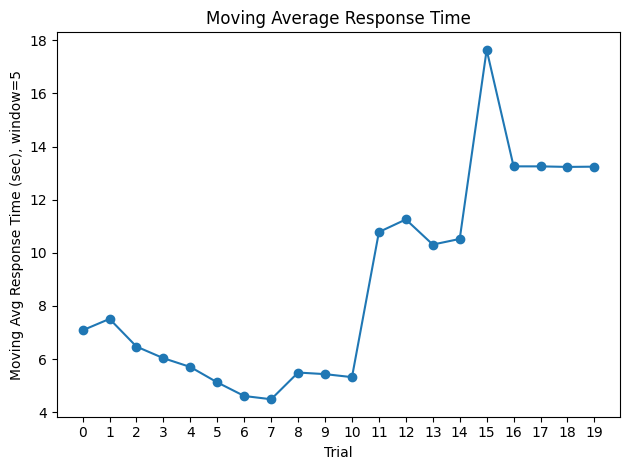

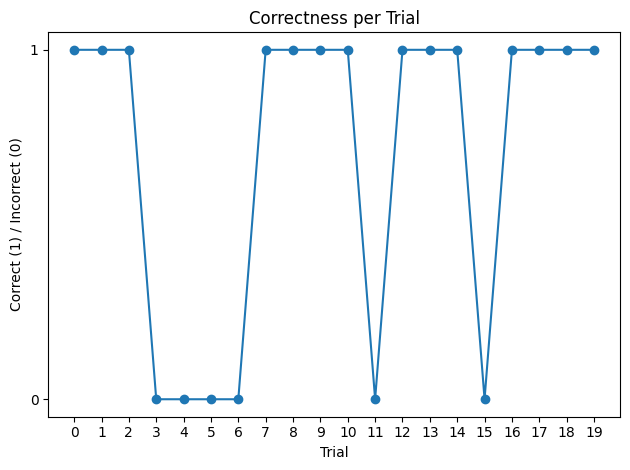

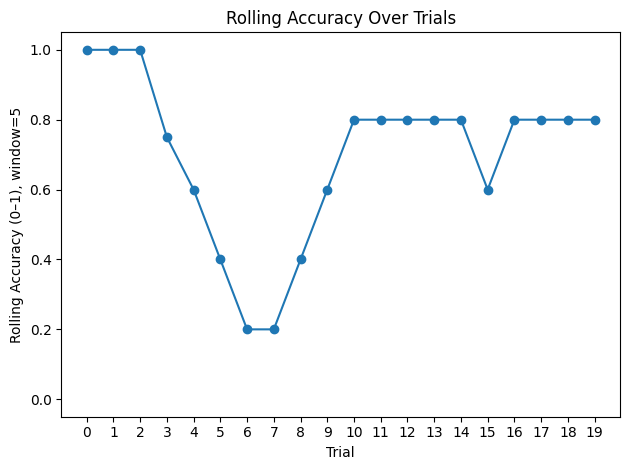


Summary by emotion:
emotion_shown  n    avg_rt  accuracy
        angry  4 13.430250     0.750
        happy  8  5.329575     0.625
      neutral  1  4.181900     0.000
          sad  4 14.816850     0.750
    surprised  3  4.891100     1.000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_LOG_PATH = "responses_log_cartoon.csv"
SESSION_ID = None
WINDOW = 5

df = pd.read_csv(CSV_LOG_PATH)


if SESSION_ID is None:

    latest_session = df["session_id"].iloc[-1]
    df_s = df[df["session_id"] == latest_session].copy()
    print("Using latest session_id:", latest_session)
else:
    df_s = df[df["session_id"] == SESSION_ID].copy()
    print("Using session_id:", SESSION_ID)


df_s = df_s.sort_values("trial_id").reset_index(drop=True)


df_s["rt_ma"] = df_s["response_time_sec"].rolling(WINDOW, min_periods=1).mean()
df_s["acc_roll"] = df_s["is_correct"].rolling(WINDOW, min_periods=1).mean()


plt.figure()
plt.plot(df_s["trial_id"], df_s["response_time_sec"], marker="o")
plt.xlabel("Trial")
plt.ylabel("Response time (sec)")
plt.title("Response Time per Trial")
plt.xticks(df_s["trial_id"])
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(df_s["trial_id"], df_s["rt_ma"], marker="o")
plt.xlabel("Trial")
plt.ylabel(f"Moving Avg Response Time (sec), window={WINDOW}")
plt.title("Moving Average Response Time")
plt.xticks(df_s["trial_id"])
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(df_s["trial_id"], df_s["is_correct"], marker="o")
plt.xlabel("Trial")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.title("Correctness per Trial")
plt.yticks([0, 1])
plt.xticks(df_s["trial_id"])
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(df_s["trial_id"], df_s["acc_roll"], marker="o")
plt.xlabel("Trial")
plt.ylabel(f"Rolling Accuracy (0–1), window={WINDOW}")
plt.title("Rolling Accuracy Over Trials")
plt.ylim(-0.05, 1.05)
plt.xticks(df_s["trial_id"])
plt.tight_layout()
plt.show()


summary = df_s.groupby("emotion_shown").agg(
    n=("emotion_shown", "count"),
    avg_rt=("response_time_sec", "mean"),
    accuracy=("is_correct", "mean")
).reset_index()

print("\nSummary by emotion:")
print(summary.to_string(index=False))
